출처 : https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough

# Costa Rican Household Poverty Level Prediction
> 코스타리카 가계 빈곤 수준 예측

## 1) Problem and Data Explanation
- train :23856 rows and 142 columns.
- test : 9557 rows and 143 colums 
- Target : 빈곤 수준 1~4

> 1 = extreme poverty 

> 2 = moderate poverty 

> 3 = vulnerable households 

> 4 = non vulnerable households



- Supervised: provided with the labels for the training data
- Multi-class classification: Labels are discrete values with 4 classes

#### **Objective**

: to predict poverty on a household level.

In orderto create a dataset for the task, we'll have to perform some aggregations of the individual data for each household. Moreover, we have to make a prediction for every individual in the test set, but "ONLY the heads of household are used in scoring" which means we want to predict poverty on a household basis. Important note: while all members of a household should have the same label in the training data, there are errors where individuals in the same household have different labels. In these cases, we are told to use the label for the head of each household, which can be identified by the rows where parentesco1 == 1.0. We will cover how to correct this in the notebook (for more info take a look at the competition main discussion).


- 각 가정에 대한 개별 aggregation 해야함 
- 가장만 scoring에 활용 > 가계 기반 빈곤 예측
-  A집 (모든 구성원 같은 label) 



<참고사항>
- ID : 각 개인에 대한 고유 식별자, 사용 X
- idhogar : 각 가구의 고유 식별자, 가구별 개인 분류
- parentescol1 : the head of the hosuehold(가장)의 여부
- Target : 모든 가구구성원이 동일한 값 가짐 

When we make a model, we'll train on a household basis with the label for each household the poverty level of the head of household. The raw data contains a mix of both household and individual characteristics and for the individual data, we will have to find a way to aggregate this for each household. Some of the individuals belong to a household with no head of household which means that unfortunately we can't use this data for training. These issues with the data are completely typical of real-world data and hence this problem is great preparation for the datasets you'll encounter in a data science job!


- 각 가정의 가장의 빈곤 수준을 측정
- raw data에는 가구 특성과 개인 특성 혼재 > 집계 방법 찾아야 함
- 개인 중 일부는 가장이 없는 가구 > 제외

### Metric (측정수단)
> **F1 score**

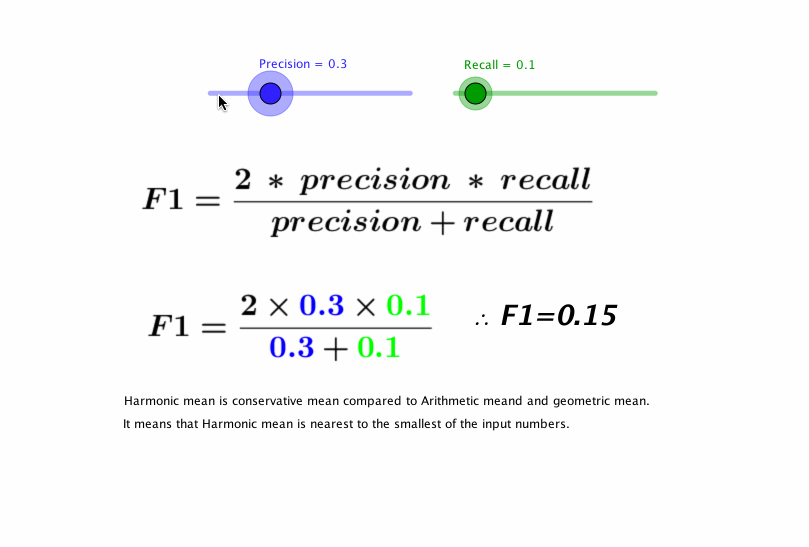
> **Macro F1 score**

For mutli-class problems, we have to average the F1 scores for each class. The macro F1 score averages the F1 score for each class without taking into account label imbalances.

Macro F1= F1 Class 1+ F1 Class 2+ F1 Class 3+ F1 Class 4/4

In other words, the number of occurrences of each label does not figure into the calculation when using macro (while it does when using the "weighted" score)

 ### Roadmap

1. Understand the problem (we're almost there already)
2. Exploratory Data Analysis
3. Feature engineering to create a dataset for machine learning
4. Compare several baseline machine learning models
5. Try more complex machine learning models
6. Optimize the selected model
7. Investigate model predictions in context of problem
9. Draw conclusions and lay out next steps

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

In [ ]:
# Read in Data and Look at Summary Information

pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('../input/costa-rican-household-poverty-prediction/train.csv')
test = pd.read_csv('../input/costa-rican-household-poverty-prediction/test.csv')
train.head()

In [ ]:
train.info()
# float64(8), int64(130), object(5)
# float > Boolean variables or ordinal variables with discrete ordered values
# object > 변환 필요

In [ ]:
test.info()

In [ ]:
description_ko=[("v2a1","월세납부"),
("hacdor","=1 침실별 과잉 수용"),
("rooms","집 안의 모든 방의 수"),
("hacapo","=1실별 과잉 수용"),
("v14a","=1 가정에 화장실 있음"),
("refrig","=1가구에 냉장고가 있는 경우"),
("v18q","태블릿 소유"),
("v18q1","가구 소유의 태블릿 수"),
("r4h1","12세 미만의 남성"),
("r4h2","남성 12세 이상"),
("r4h3","가구원수합계"),
("r4m1","12세 이하 여성"),
("r4m2","12세 이상 여성"),
("r4m3","가구원 총여성"),
("r4t1","12세 이하인 사람"),
("r4t2","12세 이상"),
("r4t3","가구원 합계"),
("tamhog","가구원수"),
("tamviv","가구원수"),
("escolari","다년간의 교육"),
("rez_esc","학창시절 몇년 뒤"),
("hhsize","가구 크기"),
("paredblolad","=1 외벽의 주요 재료가 블록 또는 벽돌인 경우"),
("paredzocalo","=1 외벽의 주요 재료가 소켓인 경우(목재, 아연 또는 압베스토"),
("paredpreb","=1 외벽의 주요 재료가 사전 조립 또는 시멘트인 경우"),
("pareddes","=1 외벽의 주요 소재가 폐자재일 경우"),
("paredmad","=1 외벽의 주요 재료가 목재인 경우"),
("paredzinc","=1 외벽의 주요 재료가 징크인 경우"),
("paredfibras","=1 외벽의 주요 소재가 천연섬유일 경우"),
("paredother","=1 외벽의 주요 재료가 다른 경우"),
("pisomoscer","=1 바닥의 주요 재료가 모자이크 세라믹 테라조인 경우"),
("pisocemento","=1 바닥의 주요 재료가 시멘트인 경우"),
("pisoother","=1 바닥의 주요 재료가 다른 경우"),
("pisonatur","=1 바닥의 주요 재료가 천연 재료인 경우"),
("pisonotiene","=가정에 층이 없는 경우 1개"),
("pisomadera","=1 바닥의 주요 재료가 목재인 경우"),
("techozinc","=1 지붕의 주요 재료가 금속 포일 또는 징크인 경우"),
("techoentrepiso","=1 지붕의 주요 재료가 섬유 시멘트, 메자닌인 경우 "),
("techocane","=1 지붕의 주요 재료가 천연 섬유인 경우"),
("techootro","=1 지붕의 주요 재료가 다른 경우"),
("cielorazo","=1 집에 천장이 있는 경우"),
("abastaguadentro","=1 주거지 내부의 급수인 경우"),
("abastaguafuera","=1 주거지 외부에 물이 공급되는 경우"),
("abastaguano","=1 물 공급이 없는 경우"),
("public","=CNFL, ICE, ESPH/JASEC에서 나오는 전기 1개"),
("planpri","=민간 발전소에서 나오는 전기 1개"),
("noelec","=1주거지에 전기가 없음"),
("coopele","=협동조합 전기 1개"),
("sanitario1","=1주거지에 화장실 없음"),
("sanitario2","=하수도 또는 하수구에 연결된 화장실 1개"),
("sanitario3","= 정화조에 연결된 화장실 1개"),
("sanitario5","=블랙홀 또는 레트린에 연결된 화장실 1개"),
("sanitario6","=다른 시스템에 연결된 화장실 1개"),
("energcocinar1","=1 요리에 사용되는 주요 에너지원이 없음(주방 없음"),
("energcocinar2","=1 전기 조리에 사용되는 주요 에너지 공급원"),
("energcocinar3","=요리가스에 사용되는 주요 에너지 공급원 1개"),
("energcocinar4","=1 목재 숯 조리에 사용되는 주요 에너지원"),
("elimbasu1","=1 유조선 트럭에 의한 쓰레기 처리의 경우"),
("elimbasu2","=1 주로 식물성 중공 또는 매립에 의한 쓰레기 처리"),
("elimbasu3","=1 주로 불에 태워 폐기물을 처리하는 경우"),
("elimbasu4","=1 빈 공간에 주로 던져서 쓰레기를 처리하는 경우"),
("elimbasu5","=1 주로 강, 하천 또는 바다에 투척하여 쓰레기를 처리하는 경우"),
("elimbasu6","=1 쓰레기 처리가 주로 다른 경우"),
("epared1","=벽이 나쁜 경우 1"),
("epared2","=1 벽이 정규적인 경우"),
("epared3","=벽이 좋은 경우 1개"),
("etecho1","=1 지붕이 나쁜 경우"),
("etecho2","=1 지붕이 정규적인 경우"),
("etecho3","=1 지붕이 양호한 경우"),
("eviv1","=1 바닥이 나쁜 경우"),
("eviv2","=1 바닥이 규칙적인 경우"),
("eviv3","=1 바닥이 좋은 경우"),
("dis","=1 장애인일 경우"),
("male","=1 남성일 경우"),
("female","=1 여성인 경우"),
("estadocivil1","=10세 미만인 경우 1개"),
("estadocivil2","=자유 또는 커플링된 경우 1개"),
("estadocivil3","=결혼한 경우 1개"),
("estadocivil4","=이혼한 경우 1개"),
("estadocivil5","=1 별거한 경우"),
("estadocivil6","=과부 경우 1개"),
("estadocivil7","=싱글일 경우 1개"),
("parentesco1","=가정의 가장일의 경우 1개"),
("parentesco2","=배우자/파트너일 경우 1개"),
("parentesco3","=아들/딸일 경우 1개"),
("parentesco4","=의붓아들/딸 일 경우"),
("parentesco5","=법률상 아들/딸일 경우 1개"),
("parentesco6","=손자/손자일 경우"),
("parentesco7","=어머니/아버지인 경우"),
("parentesco8","=법률상 아버지/어머니일 경우 1개"),
("parentesco9","=형/동생인 경우 1개"),
("parentesco10","=법률상 형제/자매인 경우 1개"),
("parentesco11","=1 다른 가족 구성원의 경우"),
("parentesco12","=1 가족이 아닌 다른 구성원의 경우"),
("idhogar","가구 수준 식별자"),
("hogar_nin","0~19세인 가구원 수 "),
("hogar_adul","어른인 가구원수"),
("hogar_mayor","65세 이상인 가구원수 "),
("hogar_total","가구원 총 인원수"),
("dependency","종속율"),
("edjefe","남성 가장의 수년간 교육"),
("edjefa","여성 가장의 수년간 교육"),
("meaneduc","평균 성인 교육년(18+)"),
("instlevel1","=1 교육 수준 없음"),
("instlevel2","=1 불완전한 초등교육"),
("instlevel3","=1 완전한 초등교육"),
("instlevel4","=1 불완전한 학업 2차 수준"),
("instlevel5","=1 완전한 학문적 2차 수준"),
("instlevel6","=1 불완전한 기술 2차 수준"),
("instlevel7","=1 완전한 기술 2차 수준"),
("instlevel8","=1학부 이상"),
("instlevel9","=1 대학원 고등교육"),
("bedrooms","침실 수"),
("overcrowding","# 객실당 인원수"),
("tipovivi1","=1자체 및 완전유급주택"),
("tipovivi2","=1개 소유, 할부 결제"),
("tipovivi3","=1 임대"),
("tipovivi4","=1 불안정한"),
("tipovivi5","=1 다른사람에게 할당된"),
("computer","=1 가구에 노트북 또는 데스크탑 컴퓨터가 있는 경우, 대여"),
("television","=1가구에 TV가 있는 경우"),
("mobilephone","=휴대전화일 경우 1"),
("qmobilephone","휴대전화 번호"),
("lugar1","=1 지역 중심"),
("lugar2","=1 지역 Chorotega"),
("lugar3","=1 지역 PacÃƒÂ­fico central"),
("lugar4","=1 지역 Brunca"),
("lugar5","=1 지역 Huetar AtlÃƒÂ¡ntica"),
("lugar6","=1 지역 Huetar Norte"),
("area1","=1 조나 우르바나"),
("area2","=2 조나 시골"),
("age","연령"),
("SQBescolari","에스코라리 제곱"),
("SQBage","나이 제곱"),
("SQBhogar_total","hogar_total 제곱"),
("SQBedjefe","에드제프 제곱"),
("SQBhogar_nin","hogar_nin 제곱"),
("SQBovercrowding","과밀 제곱"),
("SQBdependency","종속성 제곱"),
("SQBmeaned","평균 제곱"),
("agesq","나이 제곱"),]

description_ko = pd.DataFrame(description_ko, columns=['varname', 'description'])

In [ ]:
description_ko

In [ ]:
# Integer Columns
# unique 값 찾기
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color='blue', figsize = (8,6), edgecolor = 'k', linewidth=2);
plt.xlabel('Number of Unique Valeus'); plt.ylabel('Count');
plt.title('Count of Unique Values in Interger Columns')

The columns with only 2 unique values represent Booleans (0 or 1). In a lot of cases, this boolean information is already on a household level. For example, the refrig column says whether or not the household has a refrigerator. When it comes time to make features from the Boolean columns that are on the household level, we will not need to aggregate these. However, the Boolean columns that are on the individual level will need to be aggregated.

- unique 값이 2개인 column은 Booleans로 표현 가능
- Boolean 자체가 가구 수준을 나타내는 column > 집계 필요 X
- Boolean column이 개인 level을 나타낸다면 > 집계 필요 O

**Float Columns**

Another column type is floats which represent continuous variables. We can make a quick distribution plot to show the distribution of all float columns. We'll use an **OrderedDict** to map the poverty levels to colors because this keeps the keys and values in the same order as we specify (unlike a regular Python dictionary).

The following graphs shows the distributions of the float columns colored by the value of the Target. With these plots, we can see if there is a significant difference in the variable distribution depending on the household poverty level.

- OrderDict : 삽인된 순서를 기억하는 dictionary 자료형
- poverty level : color mapping

In [ ]:
from collections import OrderedDict

plt.figure(figsize = (20, 16))
plt.style.use('fivethirtyeight')

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# Iterate through the float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

Later on we'll calculate correlations between the variables and the Target to gauge the relationships between the features, but these plots can already give us a sense of which variables may be most "relevant" to a model. For example, the meaneduc, representing the average education of the adults in the household appears to be related to the poverty level: a higher average adult education leads to higher values of the target which are less severe levels of poverty. The theme of the importance of education is one we will come back to again and again in this notebook!

- 후에, target과 variable간의 correlation 파악
- ex) meaneduc : 성인의 평균 교육
- 평균 교육 수준이 높을수록 빈곤 수준이 낮아짐

In [ ]:
# Object Columns
train.select_dtypes('object').head()

id와 idhogar은 식별 변수라 object types이다. 다른 변수들은 문자와 숫자의 혼합을 보이므로 해결해야 한다.

- dependency : 종속율 : (19세 미만 가구원 수 또는 64세 이상 가구원 수)/(19~64세 가구원 수)
- edjefe : 남성 가장의 교육 연수, 성별과 가장의 상호작용에 근거, yes = 1 or no = 0 으로 대체

- edjefa : 여성 가장의 교육 연수, 성별과 가장의 상호작용에 근거, yes = 1 or no = 0으로 대체

In [ ]:
train['edjefa'].isnull().sum()

In [ ]:
mapping = {"yes": 1, "no": 0}

for df in [train, test]:
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

In [ ]:
plt.figure(figsize = (16, 12))

# Iterate through the float columns
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(3, 1, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

위 변수 모두 machine learning model에 입력 가능.

feature engineering  과정에서, test데이터와 train 데이터에 동일한 작업을 적용하기 때문에, 
두 데이터 프레임을 합치는 과정이 필요하다.

In [ ]:
# Add null Target column to test
# column 수를 맞추기 위해
test['Target'] = np.nan
data = train.append(test, ignore_index = True)

### Exploring Label Distribution
Next, we can get an idea of how imbalanced the problem is by looking at the distribution of labels. There are four possible integer levels, indicating four different levels of poverty. To look at the correct labels, we'll subset only to the columns where parentesco1 == 1 because this is the head of household, the correct label for each household.

The bar plot below shows the distribution of training labels (since there are no testing labels)

- label 분포를 통해 자료의 imbalanced 확인
- correct labels > escol == 1

In [ ]:
# 가장
heads = data.loc[data['parentesco1'] == 1].copy()

# labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1']==1), ['Target', 'idhogar']]

# value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

# 각 label 발생에 대한 bar plot
label_counts.plot.bar(figsize = (8,6),
                     color = colors.values(),
                     edgecolor = 'k', linewidth = 2)

# Formatting
plt.xlabel('Poverty Level'); plt.ylabel('Count'); 
plt.xticks([x - 1 for x in poverty_mapping.keys()], 
           list(poverty_mapping.values()), rotation = 60)
plt.title('Poverty Level Breakdown');

label_counts

- 불균형 자료(주최가 macro F1 제시한 이유)
- non vulnerable이 훨씬 많다.
- extreme class가 가장 적다.
- 불균형 분류 문제의 문제점 : minority class를 예측하기 어려움 
- 불균형 클래스 해결 방법 : oversampling

### **Addressing Wrong Labels**
- data science project 80% > 데이터 처리, 이상치 점검
- 한 가정의 개인의 빈곤 수준이 다름 > 가장을 label로 사용
- 위와 같은 경우 : 가정별 group 후 unique값이 하나인지 확인

In [ ]:
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique()==1)

not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

In [ ]:
train[train['idhogar'] == not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]
# head에 맞춰 target 재할당 필요

In [ ]:
# 가장
households_leader = train.groupby('idhogar')['parentesco1'].sum()

# 가장이 없는 경우
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader ==0].index), :]

print('There are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

In [ ]:
# Find households without a head and where labels are different
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('{} Households with no head have different labels.'.format(sum(households_no_head_equal == False)))

Well that's a relief! This means that we don't have to worry about a household both where there is no head AND the members have different values of the label! For this problem, according to the organizers, if a household does not have a head, then there is no true label. Therefore, we actually won't use any of the households without a head for training Nonetheless, it's still a good exercise to go through this process of investigating the data!

#### Correct Errors
Now we can correct labels for the households that do have a head AND the members have different poverty levels.

- 가장이 없는 경우와 가족구성원이 빈곤수준이 다른 경우는 없음
- 가장이 있고 가족 구성원이 빈곤수준이 다른 경우 수정하기 

In [ ]:
# 추가작업
for household in not_equal.index:
    # 맞는 빈곤수준 찾기(가장에 따라)
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])

    # 모든 구성원에게 correct label 부여
    train.loc[train['idhogar'] == household, 'Target'] = true_target

    # Groupby the household and figure out the number of unique valuess(일치하는 경우)
    all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
    
    # target이 불일치하는 가정
    not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

### **Missing Variables**
One of the most important steps of exploratory data analysis is finding missing values in the data and determining how to handle them. Missing values have to be filled in before we use a machine learning model and we need to think of the best strategy for filling them in based on the feature: this is where we'll have to start digging into the data definitions.

First we can look at the percentage of missing values in each column.

- EDA의 가장 중요한 단계 중 하나
- 데이터 정의를 파헤쳐야 함
- 먼저, 각 열의 결측값 퍼센트를 확인

In [ ]:
# 각 컬럼의 결측치 수
# data = train + test
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'total'})

# percentage
missing['percent'] = missing['total'] / len(data)

missing.sort_values('percent', ascending = False).head(10).drop('Target')

- Test 데이터에 Target을 NaN으로 채웠기에 drop
- v18q1 : Number of tablets 
- 가구 단위로 파악하기 위해 가장(head of household) 행 선택

In [ ]:
def plot_value_counts(df, col, heads_only = False):
    '''
    Plot value counts of a column, optionally with only the heads of a household
    '''
    # select heads of houeshold
    if heads_only:
        df = df.loc[df['parentesco1'] == 1].copy()
        
    plt.figure(figsize = (8, 6))
    df[col].value_counts().sort_index().plot.bar(color = 'blue',
                                                 edgecolor = 'k',
                                                 linewidth = 2)
    plt.xlabel(f'{col}'); plt.title(f'{col} Value Counts'); plt.ylabel('Count')
    plt.show();

In [ ]:
plot_value_counts(heads, 'v18q1')

It looks like the most common number of tablets to own is 1 if we go only by the data that is present. However, we also need to think about the data that is missing. In this case, it could be that families with a nan in this category just do not own a tablet! If we look at the data definitions, we see that v18q indicates whether or not a family owns a tablet. We should investigate this column combined with the number of tablets to see if our hypothesis holds.

We can groupby the value of v18q (which is 1 for owns a tablet and 0 for does not) and then calculate the number of null values for v18q1. This will tell us if the null values represent that the family does not own a tablet.

- 태블릿 보유 수는 1이 젤 많아 보이지만, missing 데이터도 고려해야 한다.
- v18q1(소유: 1, 소유x : 0)을 기준으로 그룹화 후 null값 계산

In [ ]:
# heads = 가장
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

Well, that solves the issue! Every family that has nan for v18q1 does not own a tablet. Therefore, we can fill in this missing value with zero.

In [ ]:
data['v18q1'] = data['v18q1'].fillna(0)

**v2a1**: Monthly rent payment(월세 지불)

The next missing column is v2a1 which represents the montly rent payment.

In addition to looking at the missing values of the monthly rent payment, it will be interesting to also look at the distribution of **tipovivi_**, the columns showing the ownership/renting status of the home. For this plot, we show the ownership status of those homes with a nan for the monthyl rent payment.

In [ ]:
# 집 소유
own_variables = [x for x in data if x.startswith('tipo')]

# Plot of the home ownership variables for home missing rent payments
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (10, 8),
                                                                        color = 'green',
                                                              edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

The meaning of the home ownership variables is below:

* tipovivi1, =1 own and fully paid house
* tipovivi2, "=1 own,  paying in installments"
* tipovivi3, =1 rented
* tipovivi4, =1 precarious
* tipovivi5, "=1 other(assigned,  borrowed)"

We've solved the issue! Well, mostly: the households that do not have a monthly rent payment generally own their own home. In a few other situations, we are not sure of the reason for the missing information.

For the houses that are owned and have a missing monthly rent payment, we can set the value of the rent payment to zero. For the other homes, we can leave the missing values to be imputed but we'll add a flag (Boolean) column indicating that these households had missing values.

- 월세 지불이 없는 가구는 보통 자기집 소유
- 월세 미납 주택 > 지불액 0으로 설정
- boolean(결측 값 있음) 열 추가

In [ ]:
# Fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

rez_esc: years behind in school(학창시절 몇년 뒤)

The last column with a high percentage of missing values is rez_esc indicating years behind in school. For the families with a null value, is possible that they have no children currently in school. Let's test this out by finding the ages of those who have a missing value in this column and the ages of those who do not have a missing value.

- null 값 > 현재 학교에 자녀가 없을 가능성 있음
- 결측값 여부에 따른 연령 파악

In [ ]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

In [ ]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

What this tells us is that the oldest age with a missing value is 17. For anyone older than this, maybe we can assume that they are simply not in school. Let's look at the ages of those who have a missing value.

If we read through some of the discussions for this competition, we learn that this variable is only defined for individuals between 7 and 19. Anyone younger or older than this range presumably has no years behind and therefore the value should be set to 0. For this variable, if the individual is over 19 and they have a missing value, or if they are younger than 7 and have a missing value we can set it to zero. For anyone else, we'll leave the value to be imputed and add a boolean flag.

- 나이가 19살 보다 많고 7살보다 어리면 결측값을 0으로 설정

In [ ]:
# If individual is over 19 or younger than 7 and missing years behind, set it to 0
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

There is also one outlier in the rez_esc column. Again, if we read through the competition discussions, we learn that the maximum value for this variable is 5. Therefore, any values above 5 should be set to 5.

- 5보다 큰 값은 5로 설정(대회규정)

In [ ]:
data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

#### Plot Two Categorical Variables
To show how two categorical variables interact with one another, there are a number of plotting options: scatterplots, faceted bar plots, boxplots, etc. I wasn't satisfied with any of these choices so I wrote the function below, which essentially is a scatterplot of two categoricals where the size of the points represent the percentage of a given y-value represented by each x-value.

- 두 범주형 변수가 서로 상호작용하는 방식을 보기 위해
- x 값과 y 백분율

In [ ]:
def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

In [ ]:
plot_categoricals('rez_esc', 'Target', data);

The size of the markers represents the raw count. To read the plot, choose a given y-value and then read across the row. For example, with a poverty level of 1, 93% of individuals have no years behind with a total count of around 800 individuals and about 0.4% of individuals are 5 years behind with about 50 total individuals in this category. This plot attempts to show both the overall counts and the within category proportion; it's not perfect , but I gave it a shot!

- marker의 크기 : raw count
- 예) 빈곤수준이 1인 경우, 93%(800명 정도) : no years behind 
-      빈곤수준이 1인 경우, 0.4%(50명 정도) : 5 years behind

In [ ]:
plot_categoricals('escolari', 'Target', data, annotate = False)

The remaining missing values in each column will be filled in, a process known as Imputation. There are several types of imputation commonly used, and one of the simplest and most effective methods is to fill in the missing values with the median of the column.

As a final step with the missing values, we can plot the distribution of target for the case where either of these values are missing.

- 결측치 채우는 가장 간단하고 효과적인 방법: 중위수

In [ ]:
plot_value_counts(data[(data['rez_esc-missing'] == 1)], 
                  'Target')

The distribution here seems to match that for all the data at large.
- 모든 데이터에 대해 일치하는 것으로 보임

In [ ]:
plot_value_counts(data[(data['v2a1-missing'] == 1)], 
                  'Target')

This looks like it could be an indicator of more poverty given the higher prevalence of 2: moderate poverty.

This represents an important point: sometimes the missing information is just as important as the information you are given.

- v2a1 중요 지표, missing 정보도 중요

## Feature Engineering
- train을 위해, 각 가정에 대한 모든 정보가 요약되어 있어야 함
- 개인을 house 기준으로 groupby하고 개별변수에 대해 aggregation을 수행

- automated feature engineering
- 기계 학습 작업의 표본

### Column Definitions
- 가구 수준에서 어떤 변수를 식별하는 방법 > 데이터 설명을 직접 살펴보기
---

The process is as follows

1. Break variables into household level and invididual level(변수를 가계 수준과 개별 수준으로 구분)
2. Find suitable aggregations for the individual level data (개별 수준에 맞는 집계 찾기)
> - Ordinal variables can use statistical aggregations 
> - Boolean variables can also be aggregated but with fewer stats
3. Join the individual aggregations to the household level data(개별 집계를 가계에 결합)


#### Define Variable Categories
1. Individual Variables: 개인 특성
> - Boolean : Yes or No
> - Ordered Discrete : Integers with an ordering

2. Household Variables
> - Boolean : Yes or No
> - Ordered Discrete : Integers with an ordering
> - Continuous numeric

3. Squared Variables: 변수 제곱
4. Id variables : feature 사용 X

아래 변수들 수동으로 정의

In [ ]:
id_ = ['Id', 'idhogar', 'Target']

In [ ]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

In [ ]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [ ]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

Let's make sure we covered all of the variables and didn't repeat any.

- 모든 변수를 반복하지 않도록

In [ ]:
x = ind_bool + ind_ordered + id_ + hh_bool + hh_ordered + hh_cont + sqr_

from collections import Counter

print('There are no repeats: ', np.all(np.array(list(Counter(x).values())) == 1))
print('We covered every variable: ', len(x) == data.shape[1])

**Squared Variables**

First, the easiest step: we'll remove all of the squared variables. Sometimes variables are squared or transformed as part of feature engineering because it can help linear models learn relationships that are non-linear. However, since we will be using more complex models, these squared features are redundant. They are highly correlated with the non-squared version, and hence can actually hurt our model by adding irrelevant information and also slowing down training.

For an example, let's take a look at SQBage vs age.

- 제곱 변수 모두 제거
- 제곱 변수 중복(비제곱 버전과 높은 상관관계) > 모델에 타격을 줌

In [ ]:
sns.lmplot('age', 'SQBage', data = data, fit_reg=False);
plt.title('Squared Age versus Age');

In [ ]:
# 높은 상관관계
# 둘다 가지고 있을 필요 없으니 제곱 데이터 삭제
data = data.drop(columns = sqr_)
data.shape

### Id Variables
These are pretty simple: they will be kept as is in the data since we need them for identification.

### Household Level Variables
First let's subset to the heads of household and then to the household level variables.
- 가장으로 부분집합 후 가구수준으로 부분집합

In [ ]:
heads = data.loc[data['parentesco1'] == 1, :]
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

For most of the household level variables, we can simply keep them as is: since we want to make predictions for each household, we use these variables as features. However, we can also remove some redundant variables and also add in some more features derived from existing data.
- 대부분 가구 수준 변수 > 유지
- 그러나, 일부 중복 변수 제거하고 기존 데이터에서 파생된 feature 추가 가능

**Redundant Household Variables**
Let's take a look at the correlations between all of the household variables. If there are any that are too highly correlated, then we might want to remove one of the pair of highly correlated variables.
- 모든 가계 변수 간 상관관계 살핀 후 높다면 한 변수 제거

The following code identifies any variables with a greater than 0.95 absolute magnitude correlation.
- 다음 코드는 상관관계가 0.95보다 큰 모든 변수를 식별한다.

In [ ]:
# Create correlation matrix
corr_matrix = heads.corr()

# Select upper triangle of correlation matrix
# np.triu: 상삼각행렬 (Upper triangular matrix)을 반환
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

These show one out of each pair of correlated variables. To find the other pair, we can subset the corr_matrix.

- 위는 상관변수의 각 쌍 중 하나, 다른 변수를 찾기 위해 부분집합 취하기

In [ ]:
# tamhog : 가구원수
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

In [ ]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9],
            annot=True, cmap = plt.cm.autumn_r, fmt='.3f');

There are several variables here having to do with the size of the house:

- r4t3, Total persons in the household(총 가구원 수)

- tamhog, size of the household(가정의 크기)

- tamviv, number of persons living in the household(가구원 수)

- hhsize, household size(가정 크기)

- hogar_total, # of total individuals in the household(가구 내 총 개인 수)


These variables are all highly correlated with one another. In fact, hhsize has a perfect correlation with tamhog and hogar_total. We will remove these two variables because the information is redundant. We can also remove r4t3 because it has a near perfect correlation with hhsize.
- 모두 서로 높은 상관관계
- 정보 중복 > 두 변수 제거(tamhog, hogar_total)(r4t3, hsize)

tamviv is not necessarily the same as hhsize because there might be family members that are not living in the household. Let's visualize this difference in a scatterplot.
- tamviv는 가구에 거주하지 않는 가족이 있을 수 있기에 반드시 hhsize와 같은 것이 아님
- 이 차이를 산점도에서 시각화


In [ ]:
heads = heads.drop(columns = ['tamhog', 'hogar_total', 'r4t3'])

In [ ]:
sns.lmplot('tamviv', 'hhsize', data, fit_reg=False, size = 8);
plt.title('Household size vs number of persons living in the household');

We see for a number of cases, there are more people living in the household than there are in the family. This gives us a good idea for a new feature: **the difference between these two measurements!**

Let's make this new feature
- 가족보다 더 많은 사람들이 살고 있다.

In [ ]:
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']
plot_categoricals('hhsize-diff', 'Target', heads)

Even though most households do not have a difference, there are a few that have more people living in the household than are members of the household.

Let's move on to the other redundant variables. First we can look at coopele

- 대부분의 가구는 차이가 없으나, 가구원보다 가정에 더 많이 살고 있는 경우가 있다.

In [ ]:
corr_matrix.loc[corr_matrix['coopele'].abs() > 0.9, corr_matrix['coopele'].abs() > 0.9]

These variables indicate where the electricity in the home is coming from. There are four options, and the families that don't have one of these two options either have no electricity (noelec) or get it from a private plant (planpri).

- coopele : 가정의 전기가 어디에서 공급되고 있는지 나타냄
- 4가지 옵션이 있으며, 
- 가족은 2가지 옵션 중 하나가 없음(전기가 없거나 플랜트 구입)

**Creating Ordinal Variable**

I'm going to compress these four variables into one by creating an ordinal variable. I'm going to choose the mapping myself, based on the data decriptions:

> 0: No electricity

> 1: Electricity from cooperative

> 2: Electricity from CNFL, ICA, ESPH/JASEC

> 3: Electricity from private plant

An ordered variable has an inherent ordering, and for this we choose our own based on the domain knowledge. After we create this new ordered variable, we can drop the four others. There are several households that do not have a variable here, so we will use a nan (which will be filled in during imputation) and add a Boolean column indicating there was no measure for this variable.
- 도메인 기반으로 자체 변수 선택
- 새로운 ordered 변수를 생성 후 4가지 옵션(변수) 삭제
- 해당이 안되면 nan 사용, 부울 열 추가

In [ ]:
elec = []

# 변수 정렬
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] ==1:
        elec.append(2)
    elif row['planpri'] ==1:
        elec.append(3)
    else:
        elec.append(np.nan)

# 새 변수 recored, missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

# Remove the electricity columns
# heads = heads.drop(columns = ['noelec', 'coopele', 'public', 'planpri'])

In [ ]:
plot_categoricals('elec', 'Target', heads)

We can see that for every value of the Target, the most common source of electricity is from one of the listed providers.

The final redundant column is area2. This means the house is in a rural zone, but it's redundant because we have a column indicating if the house is in a urban zone. Therefore, we can drop this column.

- 대부분 전기는 공급 업체에서 공급됨
- area2 : 주택이 농촌지역
- 주택이 도시 지역인지 여부를 나타내는 column이 있기에 drop한다.

In [ ]:
heads = heads.drop(columns = 'area2')

heads.groupby('area1')['Target'].value_counts(normalize = True)

It seems like households in an urban area (value of 1) are more likely to have lower poverty levels than households in a rural area (value of 0).

- 도시지역(value 1)는 농촌지역보다 빈곤도가 낮다(target 4)

#### Creating Ordinal Variables
For the walls, roof, and floor of the house, there are three columns each: the first indicating 'bad', the second 'regular', and the third 'good'. We could leave the variables as booleans, but to me it makes more sense to turn them into ordinal variables because there is an inherent order: bad < regular < good. To do this, we can simply find whichever column is non-zero for each household using np.argmax.

Once we have created the ordinal variable, we are able to drop the original variables.

- 순서 변수 생성(벽, 지붕, 바닥 변수) 후 기존 변수 삭제 가능
- np.argmax를 써서 non-zero 찾기

In [ ]:
# 기존변수 - epared1,2,3 
# bad regular good
# Wall ordinal variable
heads['walls'] = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]),
                           axis = 1)

# heads = heads.drop(columns = ['epared1', 'epared2', 'epared3'])
plot_categoricals('walls', 'Target', heads)

In [ ]:
# Roof ordinal variable
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)
heads = heads.drop(columns = ['etecho1', 'etecho2', 'etecho3'])

# Floor ordinal variable
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)
# heads = heads.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

### Feature Construction

In addition to mapping variables to ordinal features, we can also create entirely new features from the existing data, known as feature construction. For example, we can add up the previous three features we just created to get an overall measure of the quality of the house's structure.
- ex) 위 3가지 특징(지붕, 바닥, 벽)을 합쳐 집 구조의 전반적인 질 측정 가능

In [ ]:
# Create new feature
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']

plot_categoricals('walls+roof+floor', 'Target', heads, annotate=False)

This new feature may be useful because it seems like a Target of 4 (the lowest poverty level) tends to have higher values of the 'house quality' variable. We can also look at this in a table to get the fine-grained details.
- 빈곤수준 4 > house qualilty가 좋음

In [ ]:
counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(normalize=True)).rename(columns = {'Target': 'Normalized Count'}).reset_index()
counts

The next variable will be a warning about the quality of the house. It will be a negative value, with -1 point each for no toilet, electricity, floor, water service, and ceiling.
- 집 품질 경고에 대한 변수
- negative value(화장실, 전기, 바닥, 수도, 천장이 없는 경우 : -1)

In [ ]:
heads['warning'] = 1 * (heads['sanitario1'] + 
                         (heads['elec'] == 0) + 
                         heads['pisonotiene'] + 
                         heads['abastaguano'] + 
                         (heads['cielorazo'] == 0))

In [ ]:
plot_categoricals('warning', 'Target', data = heads)

In [ ]:
# violinplot : 각 그림의 폭과 y축 변수 분포 보여
plt.figure(figsize=(10,6))
sns.violinplot(x='warning', y='Target', data=heads);
plt.title('Target vs Warning variable')

The violinplot is not great here because it smooths out the categorical variable with the effect that it looks as if the Target can take on lesser and greater values than in reality. Nonetheless, we can see a high concentration of households that have no warning signs and have the lowest level of poverty. It looks as if this may be a useful feature, but we can't know for sure until we get to modeling!

The final household feature we can make for now is a bonus where a family gets a point for having a refrigerator, computer, tablet, or television.

- violinplot > 실제보다 매끄럽게 하기 때문에 정확하지는 않으나
- warning 0, target 4에 몰려있다.

In [ ]:
# 냉장고, 컴퓨터, 태블릿, tv 소유
# 왜 *1 ?
heads['bonus'] = 1 * (heads['refrig'] + 
                      heads['computer'] + 
                      (heads['v18q1'] > 0) + 
                      heads['television'])

sns.violinplot('bonus', 'Target', data = heads,
                figsize = (10, 6));
plt.title('Target vs Bonus Variable');

### Per Capita Features(1인당 특징)
Additional features we can make calculate the number of certain measurements for each person in household.

In [ ]:
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

### Exploring Household Variables

After going to all the trouble of getting our features in order, now we can take a look at them in relation to the Target. We've already done a little of this, but now we can try to quantify relationships.

### Measuring Relationships
There are many ways for measuring relationships between two variables. Here we will examine two of these:

> **The Pearson Correlation:** from -1 to 1 measuring the linear relationship between two variables
- 두 변수 간 선형 관계(관련성)

> **The Spearman Correlation:** from -1 to 1 measuring the monotonic relationship between two variables
- 두 변수간 단조 관계(순위 이용)
- 두 변수 안의 순위가 완전히 일치하면 +1이고, 두 변수의 순위가 완전히 반대이면 -1

The Spearman correlation is 1 if as one variable increases, the other does as well, even if the relationship is not linear. On the other hand, the Pearson correlation can only be one if the increase is exactly linear. These are best illustrated by example.

In [ ]:
from scipy.stats import spearmanr

In [ ]:
def plot_corrs(x, y):
    # plot data and show spearman and pearson correlation 
    
    spr = spearmanr(x, y).correlation
    pcr = np.corrcoef(x,y)[0,1]
    
    data = pd.DataFrame({'x':x, 'y':y})
    plt.figure(figsize=(6,4))
    sns.regplot('x','y', data= data, fit_reg=False);
    plt.title(f'Spearman: {round(spr, 2)}; Pearson: {round(pcr, 2)}');

In [ ]:
x = np.array(range(100))
y = x ** 2

plot_corrs(x, y)

The Spearman correlation is often considered to be better for ordinal variables such as the Target or the years of education. Most relationshisp in the real world aren't linear, and although the Pearson correlation can be an approximation of how related two variables are, it's inexact and not the best method of comparison.

- 스피어만 : tager이나 교육년도에 적합
- 실제 환경은 선형이 아니며 피어슨 상관계수가 연관성에 대한 근사치일 수 있지만 최선의 방법이 아님

In [ ]:
x = np.array([1, 1, 1, 2, 3, 3, 4, 4, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9])
y = np.array([1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 3, 3, 2, 4, 2, 2, 4])

plot_corrs(x, y)

In [ ]:
x = np.array(range(-19, 20))
y = 2 * np.sin(x)

plot_corrs(x, y)

대부분, 비슷함

In [ ]:
# Pearson correlation
# training 데이터만 사용
train_heads = heads.loc[heads['Target'].notnull(), :].copy()

pcorrs = pd.DataFrame(train_heads.corr()['Target'].sort_values()).rename(columns={'Target': 'pcorr'}).reset_index()
pcorrs = pcorrs.rename(columns = {'index': 'feature'})

print('Most negatively correlated variables:')
print(pcorrs.head())

print('\nMost positively correlated variables:')
print(pcorrs.dropna().tail())

For the negative correlations, as we increase the variable, the Target decreases indicating the poverty severity increases. Therefore, as the warning increases, the poverty level also increases which makes sense because this was meant to show potential bad signs about a house. The hogar_nin is the number of children 0 - 19 in the family which also makes sense: younger children can be financial source of stress on a family leading to higher levels of poverty. Or, families with lower socioeconomic status have more children in the hopes that one of them will be able to succeed. Whatever the explanation, there is a real link between family size and poverty
- 변수 ↑ target ↓ = 빈곤수준 ↑
- warning ↑ 빈곤수준 ↑
- hogar_nin : 0~19세인 가구원 수
- r4t1 : 12세 이하 수
- overcrowding : 객실당 수
- 사람이 늘어날수록 또는 어린 자녀가 많을 수록 가족에게 경제적 스트레스
- 가족 규모와 빈곤 사이에 연관성 있음


On the other hand, for the positive correlations, a higher value means a higher value of Target indicating the poverty severity decreases. The most highly correlated household level variable is meaneduc, the average education level of the adults in the household. This relationship between education and poverty intuitively makes sense: greater levels of education generally correlate with lower levels of poverty. We don't necessarily know which causes which, but we do know these tend to move in the same direction.
- 교육 수준이 가장 높음
- 교육과 빈곤 사이에 연관성 있음

The general guidelines for correlation values are below, but these will change depending on who you ask (source for these):

.00-.19 “very weak”
.20-.39 “weak”
.40-.59 “moderate”
.60-.79 “strong”
.80-1.0 “very strong”

What these correlations show is that there are some weak relationships that hopefully our model will be able to use to learn a mapping from the features to the Target.

Now we can move on to the **Spearman** correlation.

In [ ]:
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

feats = []
scorr = []
pvalues = []

# 각 컬럼 반복
for c in heads:
    # Only valid for numbers
    if heads[c].dtype != 'object':
        feats.append(c)
        
        # Calculate spearman correlation
        scorr.append(spearmanr(train_heads[c], train_heads['Target']).correlation)
        pvalues.append(spearmanr(train_heads[c], train_heads['Target']).pvalue)

scorrs = pd.DataFrame({'feature': feats, 'scorr': scorr, 'pvalue': pvalues}).sort_values('scorr')

The Spearman correlation coefficient calculation also comes with a pvalue indicating the significance level of the relationship. Any pvalue less than 0.05 is genearally regarded as significant, although since we are doing multiple comparisons, we want to divide the p-value by the number of comparisons, a process known as the Bonferroni correction.

- 유의수준 0.5보다 작으면 유의함
- 다중 비교: p-value를 비교 수로 나누기 > Bonferroni 보정

In [ ]:
print('Most negative Spearman correlations:')
print(scorrs.head())
print('\nMost positive Spearman correlations:')
print(scorrs.dropna().tail())

For the most part, the two methods of calculating correlations are in agreement. Just out of curiousity, we can look for the values that are furthest apart.
- 비슷 비슷
- 호기심에 가장 멀리 떨어진 변수 찾기

In [ ]:
corrs = pcorrs.merge(scorrs, on = 'feature')
corrs['diff'] = corrs['pcorr'] - corrs['scorr']

corrs.sort_values('diff').head()

In [ ]:
corrs.sort_values('diff').dropna().tail()

The largest discrepancy in the correlations is dependency. We can make a scatterplot of the Target versus the dependency to visualize the relationship. We'll add a little jitter to the plot because these are both discrete variables.

- dependency 변수가 가장 차이가 큼


In [ ]:
sns.lmplot('dependency', 'Target', fit_reg = True, data = train_heads, x_jitter=0.05, y_jitter=0.05);
plt.title('Target vs Dependency');

It's hard to see the relationship, but it's slightly negative: as the dependency increases, the value of the Target decreases. This makes sense: the dependency is the number of dependent individuals divided by the number of non-dependents. As we increase this value, the poverty severty tends to increase: having more dependent family members (who usually are non-working) leads to higher levels of poverty because they must be supported by the non-dependent family members.

- 관계라 보기 힘드나 약간 음의 관계
- 의존성 ↑ target ↓ = 빈곤수준 ↑

In [ ]:
sns.lmplot('rooms-per-capita', 'Target', fit_reg = True, data = train_heads, x_jitter=0.05, y_jitter=0.05);
plt.title('Target vs Rooms Per Capita');

**Correlation Heatmap**

One of my favorite plots is the correlation heatmap because it shows a ton of info in one image. For the heatmap, we'll pick 7 variables and show the correlations between themselves and with the target.

In [ ]:
variables = ['Target', 'dependency', 'warning', 'walls+roof+floor', 'meaneduc',
             'floor', 'r4m1', 'overcrowding']

# Calculate the correlations
corr_mat = train_heads[variables].corr().round(2)

# Draw a correlation heatmap
plt.rcParams['font.size'] = 18
plt.figure(figsize = (12, 12))
sns.heatmap(corr_mat, vmin = -0.5, vmax = 0.8, center = 0, 
            cmap = plt.cm.RdYlGn_r, annot = True);

This plot shows us that there are a number of variables that have a weak correlation with the Target. There are also high correlations between some variables (such as floor and walls+roof+floor) which could pose an issue because of collinearity.
- 서로 약한 상관관계 보임

**Features Plot**

For the final exploration of the household level data, we can make a plot of some of the most correlated variables with the Target. This shows scatterplots on the upper triangle, kernel density estimate (kde) plots on the diagonal, and 2D KDE plots on the lower triangle.

렉 > 그림 대체
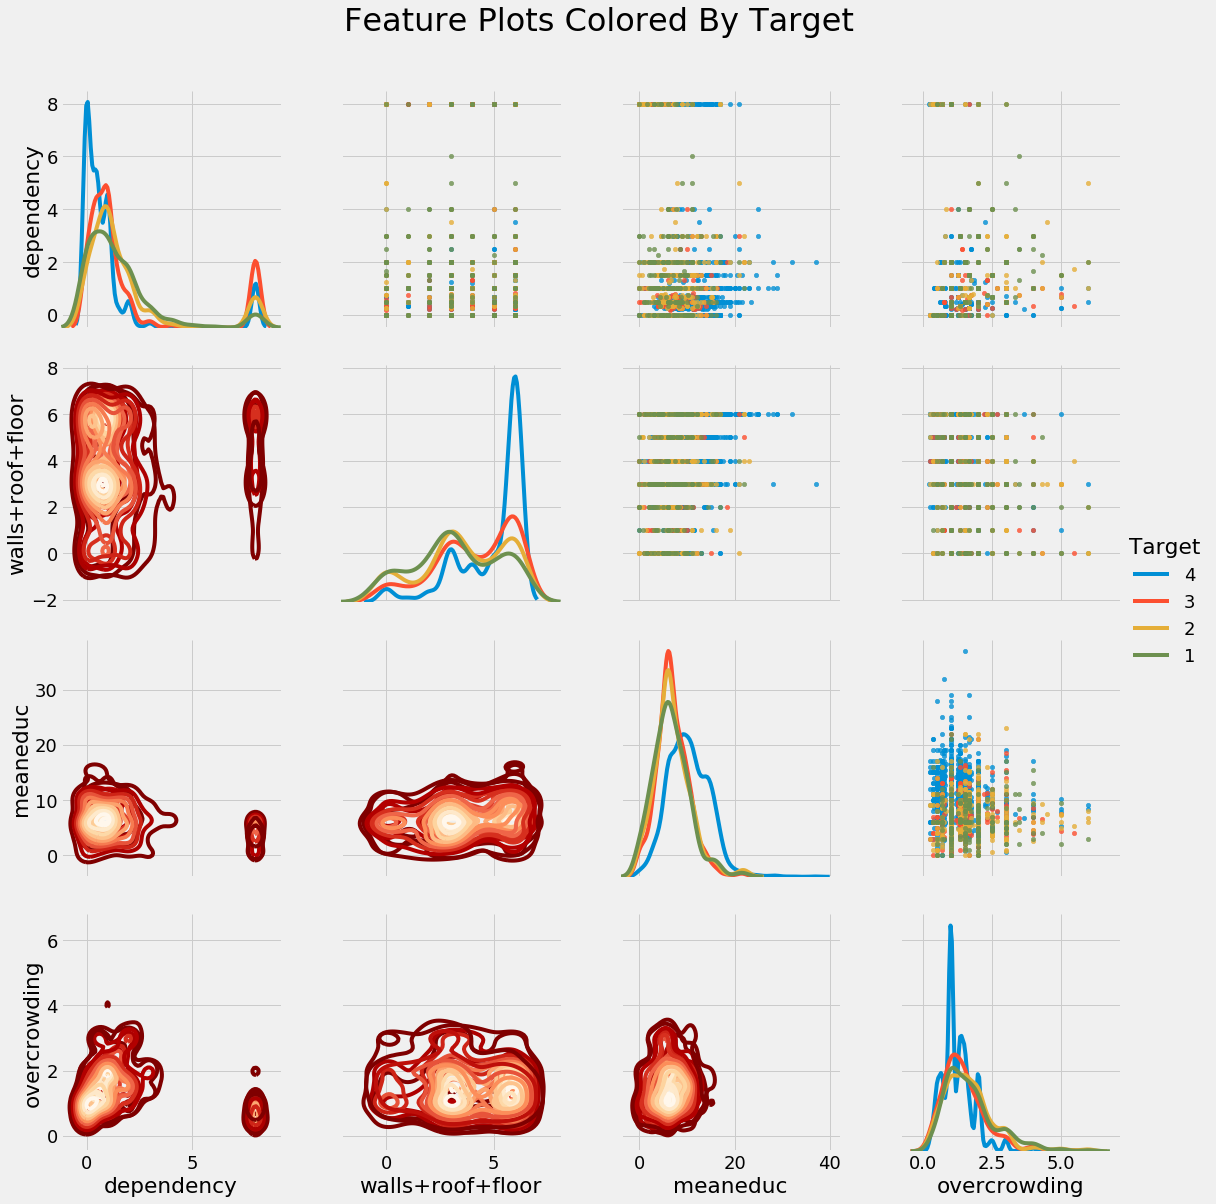!

In [ ]:
household_feats = list(heads.columns)

## Individual Level Variables
There are two types of individual level variables: Boolean (1 or 0 for True or False) and ordinal (discrete values with a meaningful ordering).

In [ ]:
ind = data[id_ + ind_bool + ind_ordered]
ind.shape

### Redundant Individual Variables
We can do the same process we did with the household level variables to identify any redundant individual variables. We'll focus on any variables that have an absolute magnitude of the correlation coefficient greater than 0.95.
- 앞선 방식과 동일하게 상관계수가 큰 변수 추출

In [ ]:
# Create correlation matrix
corr_matrix = ind.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

This is simply the opposite of male! We can remove the male flag.

In [ ]:
ind = ind.drop(columns = 'male')

### Creating Ordinal Variables
Much as we did with the household level data, we can map existing columns to an ordinal variable. Here we will focus on the instlevel_ variables which indicate the amount of education an individual has from instlevel1: no level of education to instlevel9: postgraduate education.
- 개인의 교육 수준을 나타내는 instlevel_ 변수에 초점
- instlevel1: 교육 수준 없음 ~ instlevel9: 대학원 교육

To create the ordinal variable, for each individual, we will simply find which column is non-zero. The education has an inherent ordering (higher is better) so this conversion to an ordinal variable makes sense in the problem context.
- 0이 아닌 열 찾기 

In [ ]:
ind[[c for c in ind if c.startswith('instl')]].head()

np.argmax

: 원핫인코딩에서 자주 사용, [0, 0, 0, 0, 1] 의 경우 4 출력

In [ ]:
ind['inst'] = np.argmax(np.array(ind[[c for c in ind if c.startswith('instl')]]), axis = 1)

plot_categoricals('inst', 'Target', ind, annotate = False);

Higher levels of education seem to correspond to less extreme levels of poverty. We do need to keep in mind this is on an individual level though and we eventually will have to aggregate this data at the household level.

- 교육 수준이 높을수록 빈곤 수준 떨어짐

In [ ]:
plt.figure(figsize = (10, 8))
sns.violinplot(x = 'Target', y = 'inst', data = ind);
plt.title('Education Distribution by Target');


마찬가지로, target 4에 inst가 높은 데이터 많이 분포

In [ ]:
# Drop the education columns
# ind = ind.drop(columns = [c for c in ind if c.startswith('instlevel')])
ind.shape

**Feature Construction**

We can make a few features using the existing data. For example, we can divide the years of schooling by the age.

- 연령별로 학교 년수 나누기

In [ ]:
# ("escolari","다년간의 교육")
ind['escolari/age'] = ind['escolari'] / ind['age']

plt.figure(figsize = (10, 8))
sns.violinplot('Target', 'escolari/age', data = ind);

We can also take our new variable, inst, and divide this by the age. The final variable we'll name tech: this represents the combination of tablet and mobile phones.

In [ ]:
ind['inst/age'] = ind['inst'] / ind['age']
ind['tech'] = ind['v18q'] + ind['mobilephone'] # v18q : 태블릿 소유
ind['tech'].describe()

### Feature Engineering through Aggregations
In order to incorporate the individual data into the household data, we need to aggregate it for each household. The simplest way to do this is to groupby the family id idhogar and then agg the data. For the aggregations for ordered or continuous variables, we can use six, five of which are built in to pandas, and one of which we define ourselves range_. The boolean aggregations can be the same, but this will create many redundant columns which we will then need to drop. For this case, we'll use the same aggregations and then go back and drop the redundant columns.
- 개별 데이터 + 가계 데이터 > 가구별 집계
- idhogar 로 그룹화 후 집계(aggre)
- 5개 계산, 하나 범위 지정

In [ ]:
# Define custom function
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

# Group and aggregate
ind_agg = ind.drop(columns = 'Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

In [ ]:
# Rename the columns
new_col = []
for c in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{c}-{stat}')
        
ind_agg.columns = new_col
ind_agg.head()

In [ ]:
ind_agg.iloc[:, [0, 1, 2, 3, 6, 7, 8, 9]].head()

**Feature Selection**

As a first round of feature selection, we can remove one out of every pair of variables with a correlation greater than 0.95.

In [ ]:
# Create correlation matrix
corr_matrix = ind_agg.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print(f'There are {len(to_drop)} correlated columns to remove.')

We'll drop the columns and then merge with the heads data to create a final dataframe.

In [ ]:
ind_agg = ind_agg.drop(columns = to_drop)
ind_feats = list(ind_agg.columns)

# Merge on the household id
final = heads.merge(ind_agg, on = 'idhogar', how = 'left')

print('Final features shape: ', final.shape)

In [ ]:
final.head()

**Final Data Exploration**

We'll do a little bit of exploration.

In [ ]:
corrs = final.corr()['Target']

In [ ]:
corrs.sort_values().head()

In [ ]:
corrs.sort_values().head()

In [ ]:
corrs.sort_values().dropna().tail()

We can see some of the variables that we made are highly correlated with the Target. Whether these variables are actually useful will be determined in the modeling stage.

- 새로 만든 변수 중 일부 상관관계가 높다
- escolari-max : 다년간의 교육 max

In [ ]:
plot_categoricals('escolari-max', 'Target', final, annotate=False);

In [ ]:
# violinplot
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'Target', y = 'escolari-max', data = final);
plt.title('Max Schooling by Target');

In [ ]:
# boxplot
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'escolari-max', data = final);
plt.title('Max Schooling by Target');

In [ ]:
# meaneduc : 평균 성인 교육년
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'meaneduc', data = final);
plt.xticks([0, 1, 2, 3], poverty_mapping.values())
plt.title('Average Schooling by Target');

In [ ]:
# overcrowding : 객실당 인원 수
# 인원수 적을수록 빈곤수준 낮음
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'overcrowding', data = final);
plt.xticks([0, 1, 2, 3], poverty_mapping.values())
plt.title('Overcrowding by Target');

One other feature that might be useful is the gender of the head of household. Since we aggregated the data, we'll have to go back to the individual level data and find the gender for the head of household.

- 성별 또한 중요 변수
- 가장의 성별 찾기

In [ ]:
head_gender = ind.loc[ind['parentesco1'] == 1, ['idhogar', 'female']]
final = final.merge(head_gender, on = 'idhogar', how = 'left').rename(columns = {'female': 'female-head'})

In [ ]:
final.groupby('female-head')['Target'].value_counts(normalize=True)

It looks like households where the head is female are slightly more likely to have a severe level of poverty.
- 가장이 여성인 경우, 빈곤도가 더 높다.(target 1)

In [ ]:
sns.violinplot(x = 'female-head', y = 'Target', data = final);
plt.title('Target by Female Head of Household');

We can also look at the difference in average education by whether or 
not the family has a female head of household.
- 여성 가장의 유무에 따른 평균 교육년도 차이

In [ ]:
plt.figure(figsize = (8, 8))
sns.boxplot(x = 'Target', y = 'meaneduc', hue = 'female-head', data = final);
plt.title('Average Education by Target and Female Head of Household', size = 16);

It looks like at every value of the Target, households with female heads have higher levels of education. Yet, we saw that overall, households with female heads are more likely to have severe poverty.

- Target별로 볼 때, 여성 가장인 경우 평균 교육 수준이 더 높아 보임
- 그러나, 전체적으로 보면, 여성 가장을 가진 가구는 심각한 빈곤을 겪을 가능성이 높음

In [ ]:
final.groupby('female-head')['meaneduc'].agg(['mean', 'count'])

## Machine Learning Modeling
Once feature engineering/construction is done, we can get started with the machine learning! All of our data (both training and testing) is aggregated for each household and so can be directly used in a model. To first show the process of modeling, we'll use the capable Random Forest Classifier in Scikit-Learn. This probably won't get us to the top of the leaderboard, but it will allow us to establish a baseline. Later we'll try several other models including the powerful Gradient Boosting Machine.
- random forest 분류 먼저 사용 > 기준 세우기 위해
- 그 후, GBM 등 다른 모델 사용

To assess our model, we'll use 10-fold cross validation on the training data. This will essentially train and test the model 10 times using different splits of the training data. 10-fold cross validation is an effective method for estimating the performance of a model on the test set. We want to look at the average performance in cross validation as well as the standard deviation to see how much scores change between the folds. We use the F1 Macro measure to evaluate performance.
- 모델 평가하기 위해 10-fold 교차 검증 사용
- 성능 평기하기 위해 F1 Macro 측정 사용

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Custom scorer for cross validation
# greater_is_better ?
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [ ]:
# Lables for training
train_labels = np.array(list(final[final['Target'].notnull()]['Target'].astype(np.uint8)))

# Extract the training data
train_set = final[final['Target'].notnull()].drop(columns = ['Id', 'idhogar', 'Target'])
test_set = final[final['Target'].isnull()].drop(columns = ['Id', 'idhogar', 'Target'])

# Submission base which is used for making submissions to the competition
submission_base = test[['Id', 'idhogar']].copy()

Because we are going to be comparing different models, we want to scale the features (limit the range of each column to between 0 and 1). For many ensemble models this is not necessary, but when we use models that depend on a distance metric, such as KNearest Neighbors or the Support Vector Machine, feature scaling is an absolute necessity. When comparing different models, it's always safest to scale the features. We also impute the missing values with the median of the feature.
- 서로 다른 모델 비교, 피쳐 크기 조정
- 피쳐 스케일링 (KNN, SVM에서 필요)
- 결측값 : 중위수 

For imputing missing values and scaling the features in one step, we can make a pipeline. This will be fit on the training data and used to transform the training and testing data.
- 결측값, 스케일링 한번에 > 파이프라인

In [ ]:
features = list(train_set.columns)

pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

# Fit and transform training data
train_set = pipeline.fit_transform(train_set)
test_set = pipeline.transform(test_set)

The data has no missing values and is scaled between zero and one. This means it can be directly used in any Scikit-Learn model.

In [ ]:
model = RandomForestClassifier(n_estimators = 100, random_state=10, n_jobs=-1)

# 10 fold
cv_score = cross_val_score(model, train_set, train_labels, cv = 10, scoring = scorer)
print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')


That score is not great, but it will serve as a baseline and leaves us plenty of room to improve!

- (질문)어느정도의 점수가 좋은지?

### Feature Importances
With a tree-based model, we can look at the feature importances which show a relative ranking of the usefulness of features in the model. These represent the sum of the reduction in impurity at nodes that used the variable for splitting, but we don't have to pay much attention to the absolute value. Instead we'll focus on relative scores.

If we want to view the feature importances, we'll have to train a model on the whole training set. Cross validation does not return the feature importances.

In [ ]:
model.fit(train_set, train_labels)

# Feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances.head()

In [ ]:
# feature importances를 판단할 함수
def plot_feature_importances(df, n=10, threshold = None):
    '''
    n개의 중요한 기능을 표시
    임계값이 지정된 경우, 누적 중요도 표시
    임계값 누적 중요도에 도달하는 데 필요한 피쳐 수 출력
    트리 기반 피쳐 중요도와 함께 사용 가능
    
    Args(인수):
        df: dataframe of featrue importances.
        열은 'feature', 'importance'
        
        n: feature 수, 기본값 = 15
        
        threshold(folat): threshold for cumulative importance plot. 
        입력 안 하면 플롯 생성x, 기본값 none
        
        returns:
            df : Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
        
    참고:
    - 이 경우, 정규화는 합이 1
    - 누적 중요도는 가장 중요도가 낮은 피쳐를 합산하여 계산
    - 0.9의 임계값은 누적 중요도의 90%에 도달하는 데 필요한 특성 나타냄
    
    '''
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

In [ ]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)

**Education reigns supreme!** The most important variable is the average amount of education in the household, followed by the maximum education of anyone in the household. I have a suspicion these variables are highly correlated (collinear) which means we may want to remove one of them from the data. The other most important features are a combination of variables we created and variables that were already present in the data.

It's interesting that we only need 106 of the ~180 features to account for 90% of the importance. This tells us that we may be able to remove some of the features. However, feature importances don't tell us which direction of the feature is important (for example, we can't use these to tell whether more or less education leads to more severe poverty) they only tell us which features the model considered relevant.

In [ ]:
def kde_target(df, variable):
    """Plots the distribution of `variable` in `df` colored by the `Target` column"""
    
    colors = {1: 'red', 2: 'orange', 3: 'blue', 4: 'green'}

    plt.figure(figsize = (12, 8))
    
    df = df[df['Target'].notnull()]
    
    for level in df['Target'].unique():
        subset = df[df['Target'] == level].copy()
        sns.kdeplot(subset[variable].dropna(), 
                    label = f'Poverty Level: {level}', 
                    color = colors[int(subset['Target'].unique())])

    plt.xlabel(variable); plt.ylabel('Density');
    plt.title('{} Distribution'.format(variable.capitalize()));

In [ ]:
kde_target(final, 'meaneduc')
# red : level 1, yellow : level 2, blue: level 3, green: level 4

In [ ]:
kde_target(final, 'escolari/age-range_')

## Model Selection
Now that we have a good set of features, it's time to get into the modeling. We already tried one basic model, the Random Forest Classifier which delivered a best macro F1 of 0.35. However, in machine learning, there is no way to know ahead of time which model will work best for a given dataset. The following plot shows that there are some problems where even Gaussian Naive Bayes will outperform a gradient boosting machine. This is from an excellent paper by Randal Olson that discusses many points of machine learning
- 주어진 데이터 셋에 가장 적합한 모델이 무엇인지 미리 알 수 없음

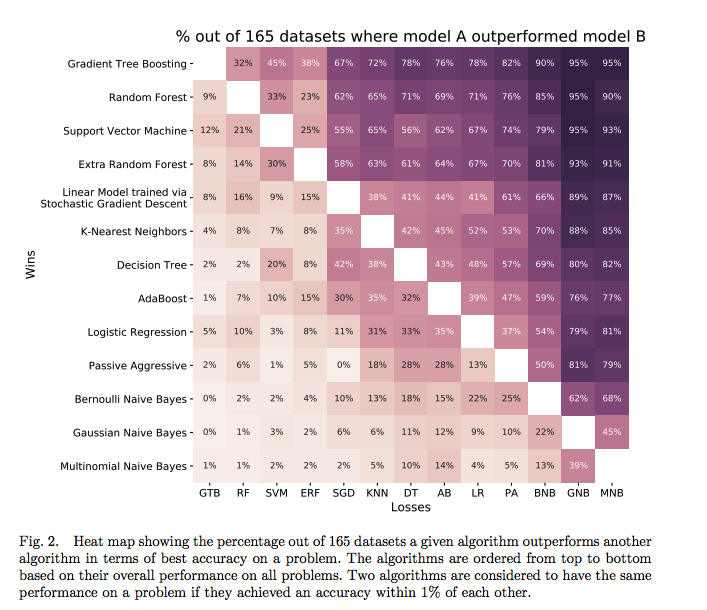
What this plot tells us is that we have to try out a number of different models to see which is optimal. Most people eventually settle on the gradient boosting machine and we will try that out, but for now we'll take a look at some of the other options. There are literally dozens (maybe hundreds) of multi-class machine learning models if we look at the Scikit-Learn documentation. We don't have to try them all, but we should sample from the options.

What we want to do is write a function that can evaluate a model. This will be pretty simple since we already wrote most of the code. In addition to the Random Forest Classifier, we'll try eight other Scikit-Learn models. Luckily, this dataset is relatively small and we can rapidly iterate through the models. We will make a dataframe to hold the results and the function will add a row to the dataframe for each model.

- 여러가지 다른 모형을 시도해야 한다

In [ ]:
# Model imports
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring=scorer, n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                            'cv_std': cv_scores.std()},
                                                           index = [0]),
                                             ignore_index = True)

        return model_results

In [ ]:
model_results = cv_model(train_set, train_labels, LinearSVC(),'LSVC', model_results)

That's one model to cross off the list (although we didn't perform hyperparameter tuning so the actual performance could possibly be improved).

In [ ]:
model_results = cv_model(train_set, train_labels, 
                         GaussianNB(), 'GNB', model_results)

That performance is very poor. I don't think we need to revisit the Gaussian Naive Bayes method (although there are problems on which it can outperform the Gradient Boosting Machine).

- model 형편 없음

In [ ]:
model_results = cv_model(train_set, train_labels, 
                         MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                         'MLP', model_results)

The multi-layer perceptron (a deep neural network) has decent performance. This might be an option if we are able to hyperparameter tune the network. However, the limited amount of data could be an issue with a neural network as these generally require hundreds of thousands of examples to learn effectively.

- 성능은 좋으나 network에 문제가 될 수도 있음

In [ ]:
model_results = cv_model(train_set, train_labels, 
                          LinearDiscriminantAnalysis(), 
                          'LDA', model_results)

If you run LinearDiscriminantAnalysis without filtering out the UserWarnings, you get many messages saying "Variables are collinear." This might give us a hint that we want to remove some collinear features! We might want to try this model again after removing the collinear variables because the score is comparable to the random forest.
- 위 모델 : 사용자 경고를 필터링하지 않으면 오류 많이 뜸
- 선형 변수를 제거한 후 다시 시도해볼수도 있음


In [ ]:
model_results = cv_model(train_set, train_labels, 
                         RidgeClassifierCV(), 'RIDGE', model_results)

The linear model (with ridge regularization) does surprisingly well. This might indicate that a simple model can go a long way in this problem (although we'll probably end up using a more powerful method).

In [ ]:
for n in [5, 10, 20]:
    print(f'\nKNN with {n} neighbors\n')
    model_results = cv_model(train_set, train_labels, 
                             KNeighborsClassifier(n_neighbors = n),
                             f'knn-{n}', model_results)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

model_results = cv_model(train_set, train_labels, 
                         ExtraTreesClassifier(n_estimators = 100, random_state = 10),
                         'EXT', model_results)

### Comparing Model Performance
With the modeling results in a dataframe, we can plot them to see which model does the best.

In [ ]:
model_results = cv_model(train_set, train_labels,
                          RandomForestClassifier(100, random_state=10),
                              'RF', model_results)

In [ ]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                  edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

**random forest > 선택**

### Making a Submission
In order to make a submission, we need the test data. Fortunately, we have the test data formatted in exactly the same manner as the train data.

The format of a testing submission is shown below. Although we are making predictions for each household, we actually need one row per individual (identified by the Id) but only the prediction for the head of household is scored.

> Id,Target

> ID_2f6873615,1

> ID_1c78846d2,2

> ID_e5442cf6a,3

> ID_a8db26a79,4

> ID_a62966799,4

The submission_base will have all the individuals in the test set since we have to have a "prediction" for each individual while the test_ids will only contain the idhogar from the heads of households. When predicting, we only predict for each household and then we merge the predictions dataframe with all of the individuals on the household id (idhogar). This will set the Target to the same value for everyone in a household. For the test households without a head of household, we can just set these predictions to 4 since they will not be scored.

- submission_base에는 각 개인에 대한 예측이 있어야 함
- 각 가구에 대해서만 예측한 뒤 예측 데이터 프레임을 idhogar의 개인과 병합
- 즉, 가구에 있는 모든 사람에게 동일한 값으로 대상 설정
- 가장이 없는 경우, 예측값 4로 설정

In [ ]:
test_ids = list(final.loc[final['Target'].isnull(), 'idhogar'])

In [ ]:
def submit(model, train, train_labels, test, test_ids):
    """Train and test a model on the dataset"""
    
    # Train on the data
    model.fit(train, train_labels)
    predictions = model.predict(test)
    predictions = pd.DataFrame({'idhogar': test_ids,
                               'Target': predictions})

     # Make a submission dataframe
    submission = submission_base.merge(predictions, 
                                       on = 'idhogar',
                                       how = 'left').drop(columns = ['idhogar'])
    
    # Fill in households missing a head
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)

    return submission 

In [ ]:
rf_submission = submit(RandomForestClassifier(n_estimators = 100, 
                                              random_state=10, n_jobs = -1), 
                         train_set, train_labels, test_set, test_ids)

rf_submission.to_csv('rf_submission.csv', index = False)

These predictions score **0.370** when submitted to the competition.

### Feature Selection
One potential method for improving model performance is feature selection. This is the process where we try to keep only the most useful features for our model. "Most useful" can mean many different things, and there are numerous heuristics for selecting the most important features. For feature selection in this notebook, we'll first remove any columns with greater than 0.95 correlation (we already did some of this during feature engineering) and then we'll apply recursive feature elimination with the Scikit-Learn library.

First up are the correlations. 0.95 is an arbitrary threshold - feel free to change the values and see how the performance changes!
- 모델 성능 개선 방안 중 하나
- 상관관계 0.95보다 큰 feature 제거

In [ ]:
train_set = pd.DataFrame(train_set, columns = features)

# Create correlation matrix
corr_matrix = train_set.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

In [ ]:
train_set = train_set.drop(columns = to_drop)
train_set.shape

In [ ]:
test_set = pd.DataFrame(test_set, columns = features)
train_set, test_set = train_set.align(test_set, axis = 1, join = 'inner')
features = list(train_set.columns)

**Recursive Feature Elimination with Random Forest**
The RFECV in Sklearn stands for Recursive Feature Elimination with Cross Validation. The selector operates using a model with feature importances in an iterative manner. At each iteration, it removes either a fraction of features or a set number of features. The iterations continue until the cross validation score no longer improves.

To create the selector object, we pass in the the model, the number of features to remove at each iteration, the cross validation folds, our custom scorer, and any other parameters to guide the selection.

- 재귀함수 제거

In [ ]:
from sklearn.feature_selection import RFECV

# Create a model for feature selection
estimator = RandomForestClassifier(random_state = 10, n_estimators = 100,  n_jobs = -1)

# Create the object
selector = RFECV(estimator, step = 1, cv = 3, scoring= scorer, n_jobs = -1)

Then we fit the selector on the training data as with any other sklearn model. This will continue the feature selection until the cross validation scores no longer improve.
- 교차 검증 점수가 더 이상 향상되지 않을 때까지 RFECV적용

In [ ]:
selector.fit(train_set, train_labels)

We can investigate the object to see the training scores for each iteration. The following code will plot the validation scores versus the number of features for the training.
- 각 반복에 대한 점수 확인

In [ ]:
plt.plot(selector.grid_scores_);

plt.xlabel('Number of Features'); plt.ylabel('Macro F1 Score'); plt.title('Feature Selection Scores');
selector.n_features_

We can see that the score improves as we add features up until 96 features. According to the selector, this is the optimal number of features.

The rankings of each feature can be found by inspecting the trained object. These represent essentially the importance of features averaged over the iterations. Features can share the same ranking, and only features with a rank of 1 are retained.

- 96개까지 기능 추가 시 성능 향상 : 최적의 feature 수
- 각 feature 순위 파악 

In [ ]:
rankings = pd.DataFrame({'feature': list(train_set.columns), 'rank': list(selector.ranking_)}).sort_values('rank')
rankings.head(10)

Finally, we select the features and then evaluate in cross validation.

In [ ]:
train_selected = selector.transform(train_set)
test_selected = selector.transform(test_set)

In [ ]:
# Convert back to dataframe
selected_features = train_set.columns[np.where(selector.ranking_==1)]
train_selected = pd.DataFrame(train_selected, columns = selected_features)
test_selected = pd.DataFrame(test_selected, columns = selected_features)

In [ ]:
model_results = cv_model(train_selected, train_labels, model, 'RF-SEL', model_results)

In [ ]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                 edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

The model with selected features does slightly better in cross-validation. We can keep both sets of features for use in our next model, the Gradient Boosting Machine.

In [ ]:
# 추후 추가 예정(GBM, LightGBM)